In [1]:
# from pyspark.sql import SparkSession 
# import pyspark.pandas as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

# spark = (
#     SparkSession.builder.appName("BNPL")
#     .config("spark.sql.repl.eagerEval.enabled", True) 
#     .config("spark.sql.parquet.cacheMetadata", "true")
#     .config("spark.driver.memory", "8g")
#     .getOrCreate()
# )

data_directory = "../data/"
tables_directory = data_directory + "tables/"
merchant_fraud_directory = tables_directory + "merchant_fraud_probability.csv"
consumer_fraud_directory = tables_directory + "consumer_fraud_probability.csv"

In [2]:
# Getting transaction data and remove merchants not listed in transactions
def normalise_tags(merchants):
    merchants[["sector_tags", "revenue_band", "take_rate"]] = merchants.apply(lambda row: process_tags(row.tags),axis='columns', result_type='expand')
    merchants["sector_tags"] = merchants["sector_tags"].str.lower().str.replace(' +', ' ', regex=True).str.strip()
    return merchants
def process_tags(tag):
    result = re.search(r'^[\[\(]{2}(.+?(?:, ?.+)*)[\]\)], [\[\(]([a-z])[\]\)], [\(\[].+: (\d+\.?\d+)[\)\]]{2}$', tag)
    return result.group(1), result.group(2), result.group(3)

merchants = normalise_tags(pd.read_parquet("../data/tables/tbl_merchants.parquet"))
transactions_directories = ["../data/tables/transactions_20210228_20210827_snapshot"
                  ,"../data/tables/transactions_20210828_20220227_snapshot"
                  ,"../data/tables/transactions_20220228_20220828_snapshot"]
transactions = pd.concat([pd.read_parquet(trans_dir) for trans_dir in transactions_directories])
transactions = transactions[transactions["merchant_abn"].isin(merchants.index.to_numpy())]
transactions


user_id  merchant_abn  dollar_value  \
0              1   28000487688    133.226894   
1          18485   62191208634     79.131400   
2              1   83690644458     30.441348   
3          18488   39649557865    962.813341   
4              2   80779820715     48.123977   
...          ...           ...           ...   
6044127    11135   49891706470     24.174809   
6044129    11136   24852446429      5.384811   
6044130    11136   63685007785     48.129887   
6044131    11137   85502310765      4.768752   
6044132    11138   43186523025     35.127668   

                                     order_id order_datetime  
0        0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea     2021-02-28  
1        9e18b913-0465-4fd4-92fd-66d15e65d93c     2021-02-28  
2        40a2ff69-ea34-4657-8429-df7ca957d6a1     2021-02-28  
3        f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a     2021-02-28  
4        cd09bdd6-f56d-489f-81ea-440f4bda933c     2021-02-28  
...                                       ...            ...  
6044127  0c955d44-b77b-4cfb-be2f-b5a2d19386ef     2022-10-26  
6044129  ba2ce936-ae49-4b70-a4b1-e8f8bacaefb3     2022-10-26  
6044130  a6194c61-ae7a-4037-a425-2dd7cda42fb7     2022-10-26  
6044131  72a3639e-25d5-4bcc-9e8b-26e737b8c0e4     2022-10-26  
6044132  3f3b1d40-e8ec-4d4b-ac08-5f273586523c     2022-10-26  

[13614675 rows x 5 columns]

In [3]:
merchant_fraud_prob = pd.read_csv(merchant_fraud_directory)
consumer_fraud_prob = pd.read_csv(consumer_fraud_directory)

In [4]:
merchant_fraud_prob.nunique()

merchant_abn          61
order_datetime        64
fraud_probability    113
dtype: int64

In [5]:
consumer_fraud_prob.nunique()

user_id              20128
order_datetime         365
fraud_probability    34765
dtype: int64

We see that 61 merchants and 20,128 consumers were chosen for fraud transactions

In [6]:
merchant_fraud_prob["order_datetime"] = pd.to_datetime(merchant_fraud_prob["order_datetime"])
consumer_fraud_prob["order_datetime"] = pd.to_datetime(consumer_fraud_prob["order_datetime"])
transactions["order_datetime"] = pd.to_datetime(transactions["order_datetime"])

In [7]:
consumer_fraud_prob

user_id order_datetime  fraud_probability
0         6228     2021-12-19          97.629808
1        21419     2021-12-10          99.247380
2         5606     2021-10-17          84.058250
3         3101     2021-04-17          91.421921
4        22239     2021-10-19          94.703425
...        ...            ...                ...
34859    18466     2022-02-22           8.679873
34860    17552     2021-12-26           8.349463
34861    17875     2021-06-27           8.288847
34862    10401     2021-09-18           8.842216
34863    18076     2021-11-30           8.542029

[34864 rows x 3 columns]

<AxesSubplot:xlabel='merchant_abn', ylabel='count'>

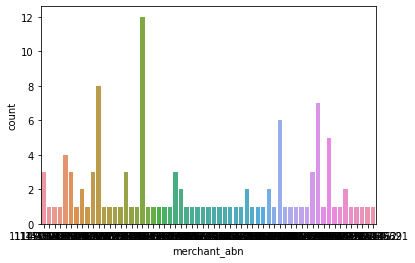

In [8]:
sns.countplot(x=merchant_fraud_prob['merchant_abn'])

In [9]:
merchant_fraud_total = transactions.merge(merchant_fraud_prob, how='inner', on=['merchant_abn', 'order_datetime'])
merchant_fraud_total

user_id  merchant_abn   dollar_value  \
0       19453   83199298021   13887.358607   
1        2550   83199298021   37808.999083   
2       13492   83199298021   42423.651280   
3        3101   91880575299  105193.885789   
4         230   11149063370   47346.113374   
...       ...           ...            ...   
3998    14249   90918180829    5516.391447   
3999    16556   35575706403   50209.505439   
4000    17900   11149063370   42797.348359   
4001     3513   83199298021   44471.999391   
4002    10665   83199298021   15208.650153   

                                  order_id order_datetime  fraud_probability  
0     4d1ee9ac-2858-46d6-883a-4006ff8e5073     2021-03-25          69.085569  
1     bf73265f-fcd0-4f09-adf3-56ede1f14fa1     2021-03-25          69.085569  
2     f387a556-8246-4459-8390-51f3db8ed1c3     2021-03-25          69.085569  
3     2ab65c8f-11b2-41cb-8889-001ce62c005d     2021-04-17          32.994978  
4     6c3eb0dc-1235-4e1a-8664-8553579ae005     2021-08-28          56.437613  
...                                    ...            ...                ...  
3998  1d855cc0-4e3a-4998-a22c-ac855cbdedae     2022-02-19          30.975819  
3999  d444e831-764d-4ca1-b880-e552a6c0add9     2022-02-20          91.096068  
4000  b0bdd444-223a-4b4f-98f3-7e2bba125691     2022-02-25          51.015384  
4001  4463230f-9745-4a4a-9f5a-2609f8d549b2     2022-02-27          26.025159  
4002  ed623045-9c0e-4e10-a332-2ad7b89a8c5d     2022-02-27          26.025159  

[4003 rows x 6 columns]

In [10]:
list(merchant_fraud_total.columns)

['user_id',
 'merchant_abn',
 'dollar_value',
 'order_id',
 'order_datetime',
 'fraud_probability']

In [12]:
merchant_fraud_total

user_id  merchant_abn   dollar_value  \
0       19453   83199298021   13887.358607   
1        2550   83199298021   37808.999083   
2       13492   83199298021   42423.651280   
3        3101   91880575299  105193.885789   
4         230   11149063370   47346.113374   
...       ...           ...            ...   
3998    14249   90918180829    5516.391447   
3999    16556   35575706403   50209.505439   
4000    17900   11149063370   42797.348359   
4001     3513   83199298021   44471.999391   
4002    10665   83199298021   15208.650153   

                                  order_id order_datetime  fraud_probability  
0     4d1ee9ac-2858-46d6-883a-4006ff8e5073     2021-03-25          69.085569  
1     bf73265f-fcd0-4f09-adf3-56ede1f14fa1     2021-03-25          69.085569  
2     f387a556-8246-4459-8390-51f3db8ed1c3     2021-03-25          69.085569  
3     2ab65c8f-11b2-41cb-8889-001ce62c005d     2021-04-17          32.994978  
4     6c3eb0dc-1235-4e1a-8664-8553579ae005     2021-08-28          56.437613  
...                                    ...            ...                ...  
3998  1d855cc0-4e3a-4998-a22c-ac855cbdedae     2022-02-19          30.975819  
3999  d444e831-764d-4ca1-b880-e552a6c0add9     2022-02-20          91.096068  
4000  b0bdd444-223a-4b4f-98f3-7e2bba125691     2022-02-25          51.015384  
4001  4463230f-9745-4a4a-9f5a-2609f8d549b2     2022-02-27          26.025159  
4002  ed623045-9c0e-4e10-a332-2ad7b89a8c5d     2022-02-27          26.025159  

[4003 rows x 6 columns]

In [13]:
merch_grouped = merchant_fraud_total[['merchant_abn', 'order_datetime', 'fraud_probability']]
merch_distinct_grouped = merch_grouped.drop_duplicates()

<AxesSubplot:xlabel='dollar_value', ylabel='fraud_probability'>

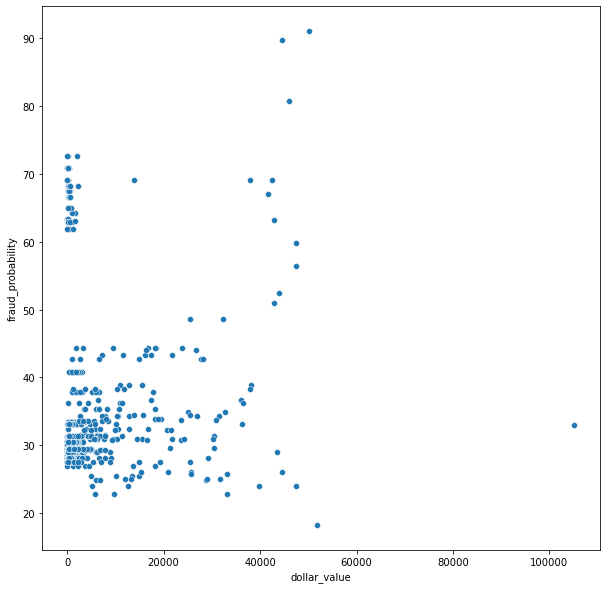

In [14]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=merchant_fraud_total, x='dollar_value', y='fraud_probability')

Looking at the scatterplot, we see that most frauds would occur below $5,000. To gain more details, we will look at the counts. With regards to the relationship between fraud probability and dollar value, we do not see much of a relationship. Most fraud probabilities were below 50\% with some exceptions at the top left which should be investigated further. 

In [15]:
merchant_fraud_total[merchant_fraud_total['dollar_value'] < 500]

user_id  merchant_abn  dollar_value  \
6         212   80089686333    227.761831   
8        5461   80089686333    337.592034   
9       10302   80089686333    381.965617   
20       2289   31334588839     94.052274   
28      21903   18737319630    185.212946   
...       ...           ...           ...   
3922     2874   31334588839     54.832316   
3947     3169   31334588839    251.868675   
3958    21321   78187460332     85.547328   
3959    10568   78187460332    368.935407   
3961    13200   78187460332    104.827562   

                                  order_id order_datetime  fraud_probability  
6     a947818c-412c-4dfe-80d2-df7f498d5f0c     2021-09-01          67.505811  
8     511f5ee9-a04f-482f-a998-c115c917cc82     2021-09-01          67.505811  
9     362856dc-b703-4262-a6eb-2720564ba380     2021-09-01          67.505811  
20    a8e5996f-2095-4e35-bafa-e4269d3b9fd1     2021-09-23          32.389085  
28    e53d6628-ead8-4618-a041-85ecb41a2770     2021-09-25          72.730697  
...                                    ...            ...                ...  
3922  dd429d28-b62b-4ccc-8823-0212c81e5ebd     2021-12-12          27.514968  
3947  fd159bb0-ad02-48c1-a3ef-1a1c1f09a9a2     2021-12-18          27.534942  
3958  d5efccf2-4476-4f45-be08-4726318316dd     2021-12-19          65.005764  
3959  be8d2254-9e41-4dee-83fb-b9b921bd0f2e     2021-12-19          65.005764  
3961  0b702ee0-9395-43ad-b877-e046985a89c9     2021-12-19          65.005764  

[3175 rows x 6 columns]

We see that most of the dollar values were below $500 which represented 82.15\% of the fraud data. 

(0.0, 1000.0)

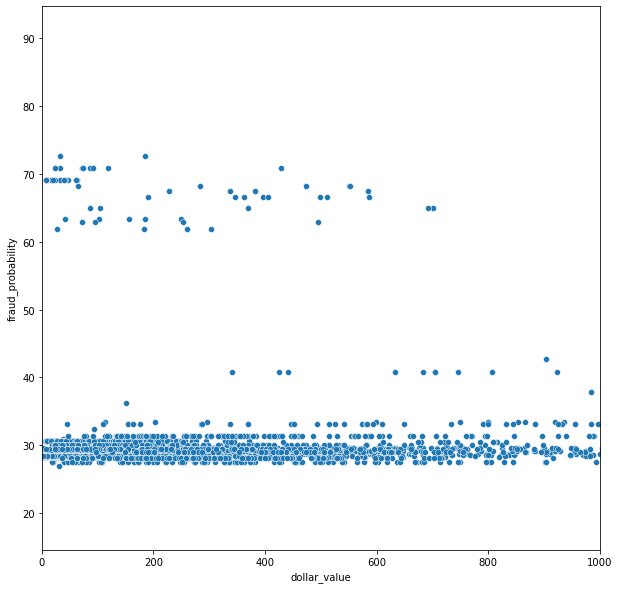

In [16]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=merchant_fraud_total, x='dollar_value', y='fraud_probability')
plt.xlim((0,1000))

Zooming in, we still do not see a clear relationship between the dollar values and fraud probability. 

(0.0, 1000.0)

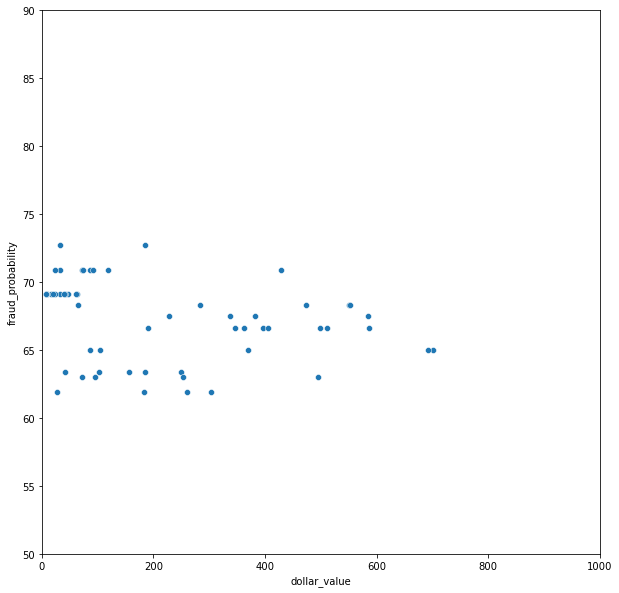

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=merchant_fraud_total, x='dollar_value', y='fraud_probability')
plt.ylim((50,90))
plt.xlim((0,1000))

This cluster has fraud rate of over 60% which is high. We will investigate further to see if it belongs to a specific merchant or consumer

In [18]:
cluster = merchant_fraud_total[merchant_fraud_total['fraud_probability']>60]

In [19]:
cluster

user_id  merchant_abn  dollar_value  \
0       19453   83199298021  13887.358607   
1        2550   83199298021  37808.999083   
2       13492   83199298021  42423.651280   
6         212   80089686333    227.761831   
7       18317   80089686333    584.378059   
...       ...           ...           ...   
3960    10895   78187460332    692.744822   
3961    13200   78187460332    104.827562   
3976     2310   79100970961  41689.730399   
3984    19159   30275989942   1558.875975   
3999    16556   35575706403  50209.505439   

                                  order_id order_datetime  fraud_probability  
0     4d1ee9ac-2858-46d6-883a-4006ff8e5073     2021-03-25          69.085569  
1     bf73265f-fcd0-4f09-adf3-56ede1f14fa1     2021-03-25          69.085569  
2     f387a556-8246-4459-8390-51f3db8ed1c3     2021-03-25          69.085569  
6     a947818c-412c-4dfe-80d2-df7f498d5f0c     2021-09-01          67.505811  
7     4ace0eec-e2d6-419f-b205-c048eb271dd6     2021-09-01          67.505811  
...                                    ...            ...                ...  
3960  93c254fd-51d8-4627-80e1-850d3025fb3d     2021-12-19          65.005764  
3961  0b702ee0-9395-43ad-b877-e046985a89c9     2021-12-19          65.005764  
3976  a40ffe64-0e3a-4899-bbd3-04760ec5461f     2022-01-02          67.117740  
3984  9ab71367-e993-4c05-87e1-18450df058db     2022-01-28          63.108593  
3999  d444e831-764d-4ca1-b880-e552a6c0add9     2022-02-20          91.096068  

[73 rows x 6 columns]

In [20]:
cluster.nunique()

user_id              73
merchant_abn         18
dollar_value         73
order_id             73
order_datetime       17
fraud_probability    18
dtype: int64

In [21]:
cluster.count()

user_id              73
merchant_abn         73
dollar_value         73
order_id             73
order_datetime       73
fraud_probability    73
dtype: int64

We should go into more details on the 11 merchants especially where the counts were high for the transactions per merchant at the specific date. A possible explanation could be scalping bots in that case. 

Due to the limited fraud data, we are not able to check the fraud probabilities trend using time-series data

With regards to the consumer fraud data, it would not make sense if it was randomly drawn as we do not get an exact reference to how the transactions of consumers and if they were or were not fraud transactions. If a customer did purchase a few high purchases but only one of the transactions are given with fraud probability while the others are not given, we would think that the fraud was just a one time thing when actually all the high purchases were frauds which would be alarming. 

# checking for consumers

In [22]:
consumer_fraud_total = transactions.merge(consumer_fraud_prob, how='inner', on=['user_id', 'order_datetime'])
consumer_fraud_total

user_id  merchant_abn  dollar_value  \
0        21989   31334588839  14080.096388   
1        21989   14430838529     74.674454   
2         4144   45629217853      3.167339   
3         4351   64203420245     49.474965   
4         4952   21439773999     76.071035   
...        ...           ...           ...   
71811    14526   32173481131   3672.263901   
71812    14542   12771097467   2727.032466   
71813    14743   63937753588   3064.467853   
71814    14743   49322182190    113.319209   
71815    14743   49212265466    273.452318   

                                   order_id order_datetime  fraud_probability  
0      fb7a786e-b329-4615-8463-506cf275efeb     2021-02-28          21.272297  
1      f539f668-d07b-4685-a082-fd017088e4bc     2021-02-28          21.272297  
2      27ba867c-cb07-43a7-8848-4a2791b3933c     2021-02-28           9.689173  
3      e181ac26-22fd-42dc-b73d-03f97a43a765     2021-02-28          13.006904  
4      c5a1db63-fdc0-46f6-8dfb-0caae9a0dfe2     2021-02-28           9.131704  
...                                     ...            ...                ...  
71811  e580855a-dd90-44b0-9413-1de87389fa7e     2022-02-27          10.989992  
71812  f61c3255-bb75-4289-995c-281207db82cd     2022-02-27           9.050576  
71813  f7715cb1-8879-4d54-915a-95d17326b667     2022-02-27          14.079151  
71814  2d636ee7-abdd-4f81-abc1-6b7c85d5d1f2     2022-02-27          14.079151  
71815  6613dff7-3ce0-4b30-9d31-86cc524ac273     2022-02-27          14.079151  

[71816 rows x 6 columns]

In [23]:
consumer_fraud_total.nunique()

user_id              19513
merchant_abn          3258
dollar_value         71488
order_id             71637
order_datetime         365
fraud_probability    32678
dtype: int64

As seen, we have reduced number of unique user_ids. This is due to the fact that we already removed those likely fraud accounts when we did outlier detection. We can further improve the dataset by seeing if we can learn anything from the fraud data with the remaining deemed suspicious transactions.

In [24]:
fraud_consumers= list(consumer_fraud_total['user_id'].unique())
fraud_consumers

[21989,
 4144,
 4351,
 4952,
 5209,
 9229,
 9279,
 11870,
 12185,
 13039,
 13663,
 13856,
 15663,
 15896,
 17134,
 17365,
 17645,
 18324,
 254,
 1060,
 20948,
 22283,
 22472,
 8400,
 8481,
 11858,
 14691,
 18594,
 21806,
 4524,
 23896,
 5847,
 6404,
 8769,
 9220,
 10218,
 11544,
 13156,
 16750,
 2388,
 2810,
 3348,
 3822,
 23109,
 23590,
 9088,
 10370,
 10639,
 10882,
 11547,
 11899,
 13052,
 16000,
 18833,
 488,
 1200,
 3576,
 22355,
 4192,
 23252,
 23363,
 23927,
 6016,
 7791,
 8865,
 9418,
 11013,
 11218,
 15138,
 16990,
 50,
 345,
 18850,
 1123,
 20111,
 2964,
 22153,
 4375,
 4445,
 4899,
 6788,
 7542,
 10530,
 11497,
 11966,
 12152,
 13260,
 13724,
 17352,
 20547,
 2764,
 2832,
 3146,
 8348,
 8423,
 11479,
 13558,
 14680,
 15231,
 15733,
 18396,
 711,
 845,
 19352,
 1029,
 19577,
 20277,
 2441,
 3531,
 4521,
 23751,
 8446,
 8522,
 10990,
 11685,
 14802,
 16734,
 19003,
 19213,
 19354,
 19357,
 19967,
 20049,
 1854,
 2029,
 2440,
 22051,
 3770,
 4336,
 4968,
 7133,
 7547,
 13802,
 

In [25]:
# Now we sample randomly from the consumers
random.seed(42)
fraud_consumers_sample = random.choices(fraud_consumers, k=100)

In [26]:
# Now we will collate all transactions relating to those consumers and group by day per consumer
collated_transactions = transactions[transactions['user_id'].isin(fraud_consumers_sample)]
consumer_transactions_day = collated_transactions.groupby(['user_id', 'order_datetime']).agg(total_dollar=pd.NamedAgg(column='dollar_value', aggfunc="sum")).reset_index()
consumer_transactions_day


user_id order_datetime  total_dollar
0           21     2021-03-04     73.699198
1           21     2021-03-07     49.573876
2           21     2021-03-09     34.899172
3           21     2021-03-10    257.428281
4           21     2021-03-11    106.569287
...        ...            ...           ...
36332    23609     2022-10-21    178.885454
36333    23609     2022-10-22     34.806934
36334    23609     2022-10-24    178.171173
36335    23609     2022-10-25    414.799429
36336    23609     2022-10-26     16.316832

[36337 rows x 3 columns]

<ipython-input-27-0085236eab13>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


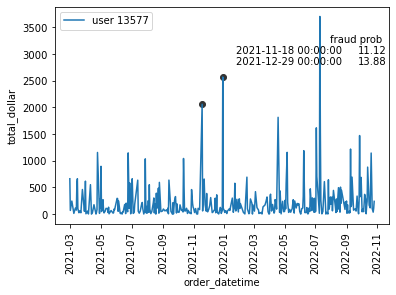

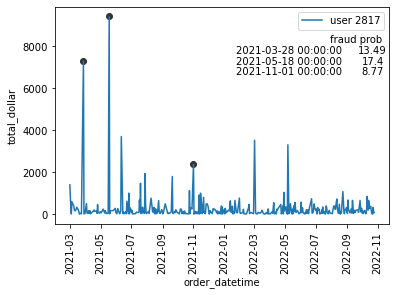

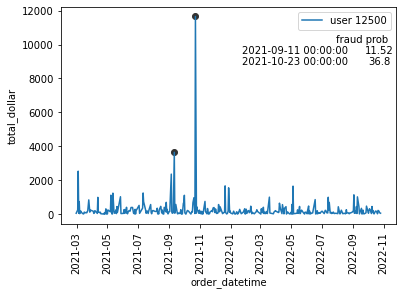

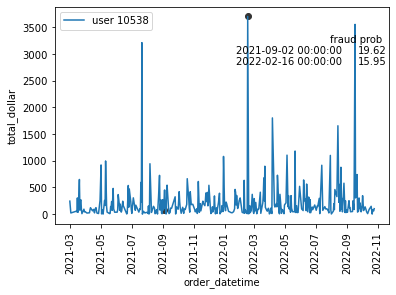

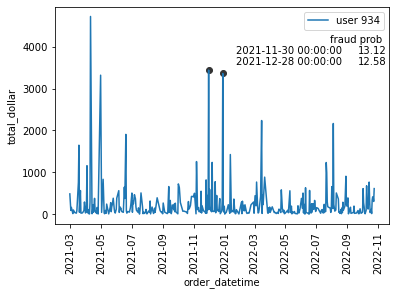

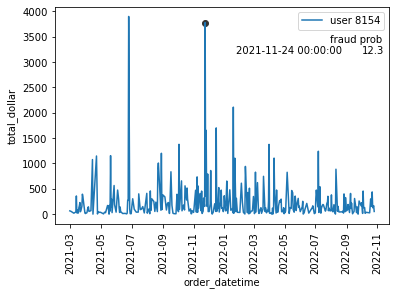

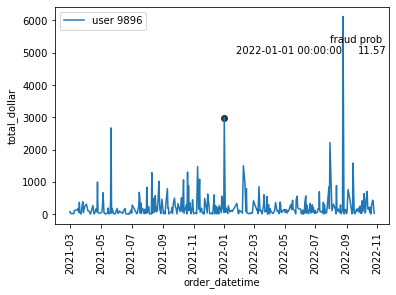

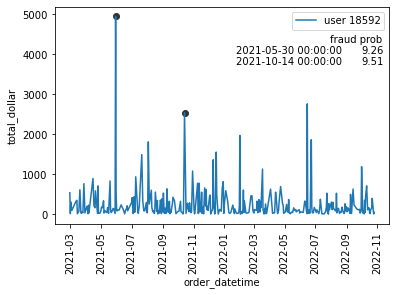

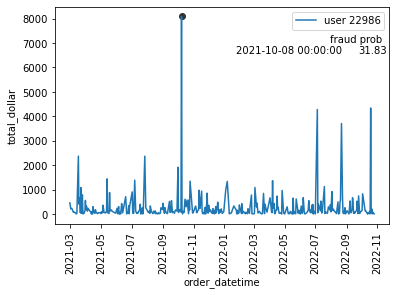

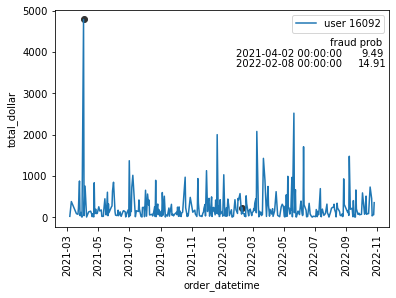

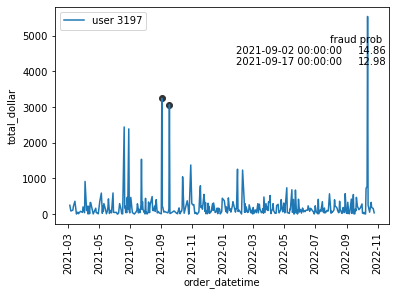

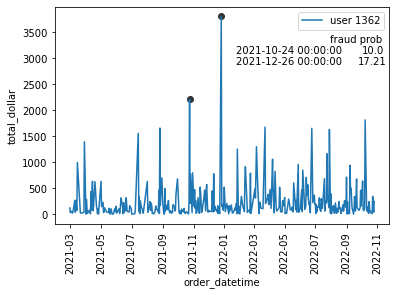

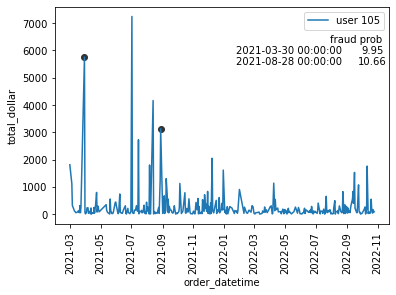

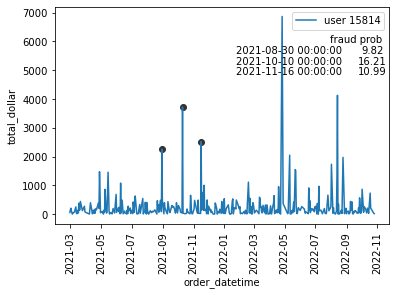

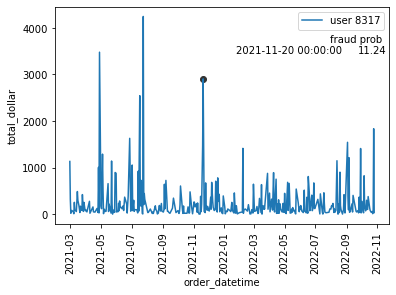

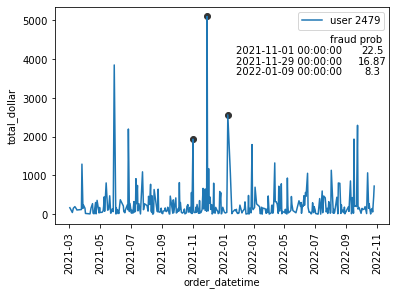

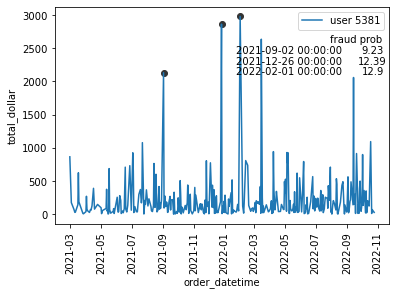

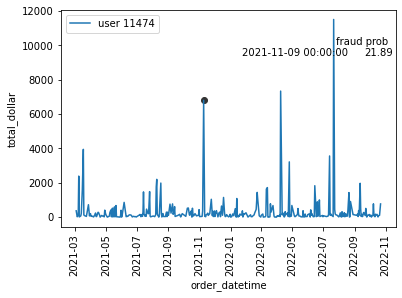

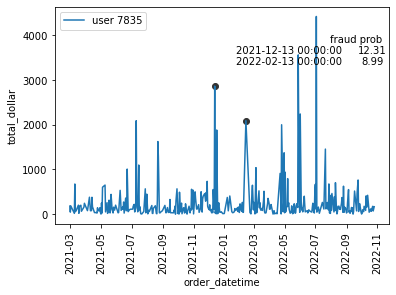

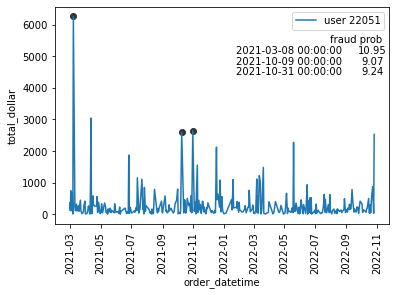

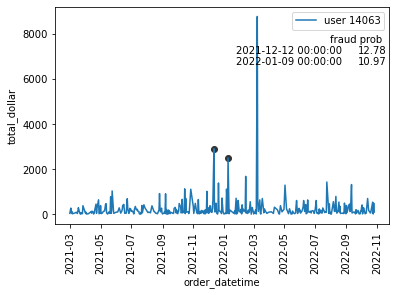

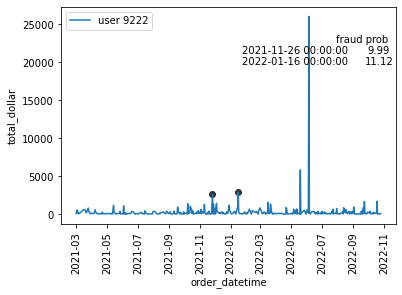

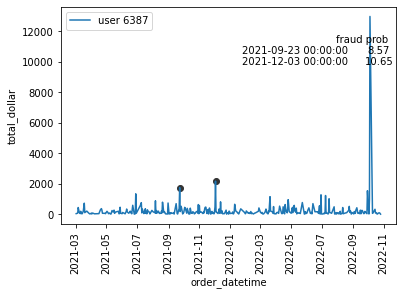

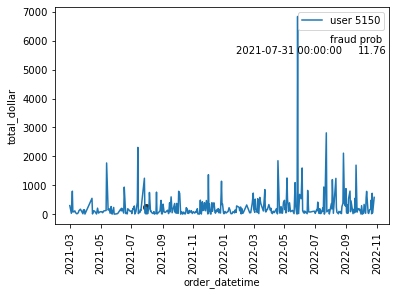

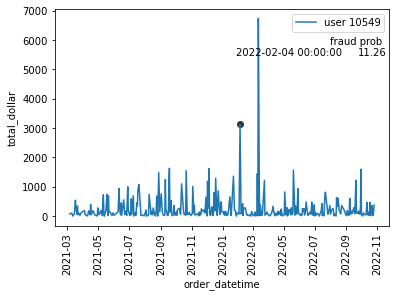

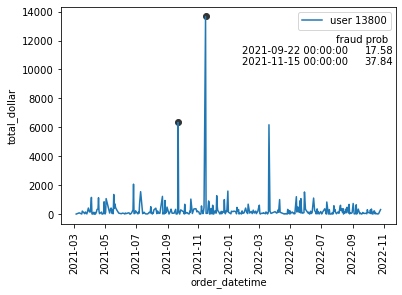

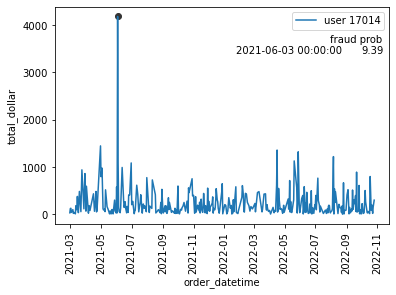

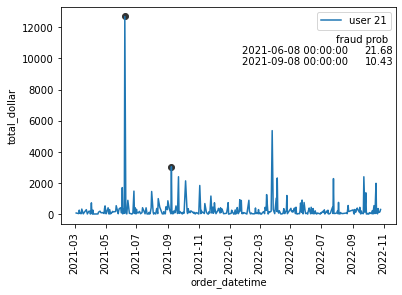

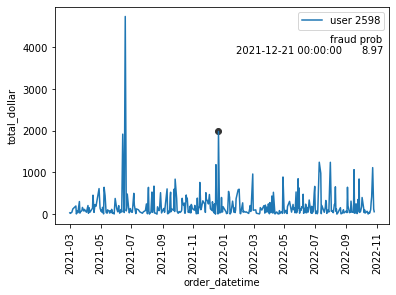

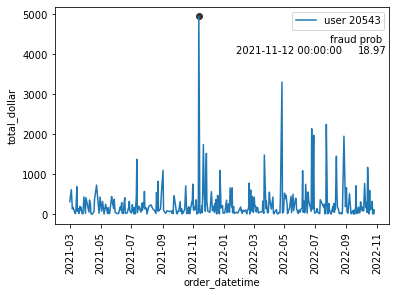

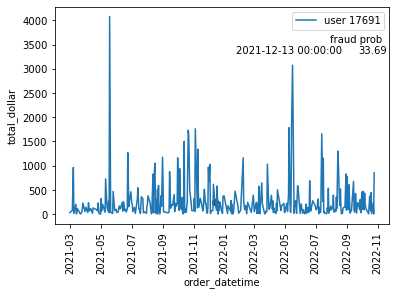

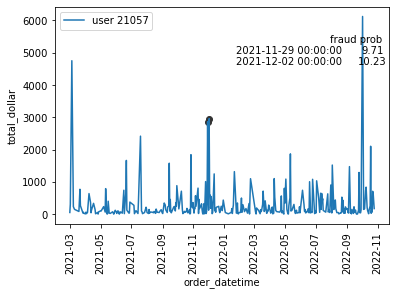

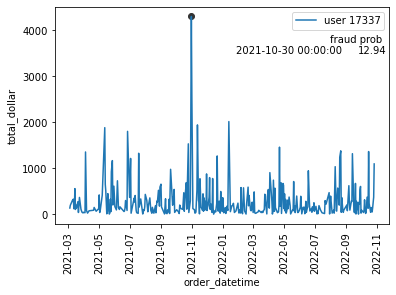

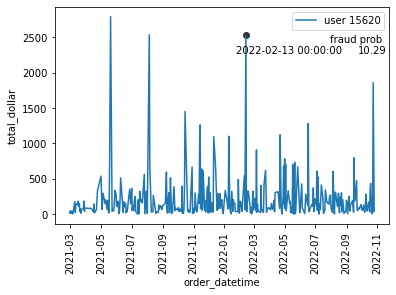

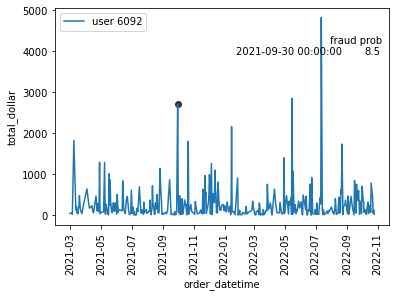

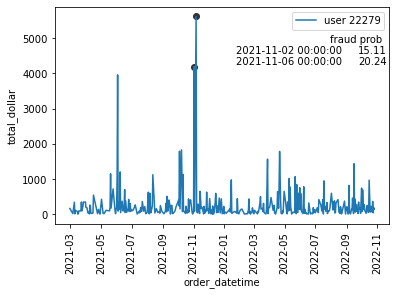

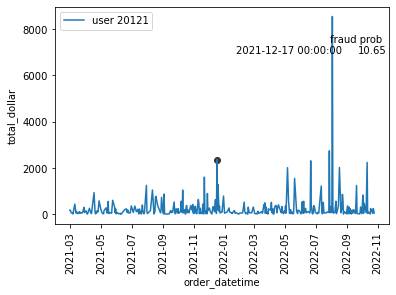

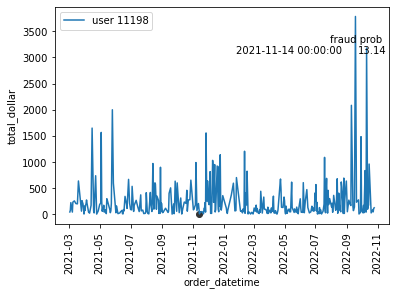

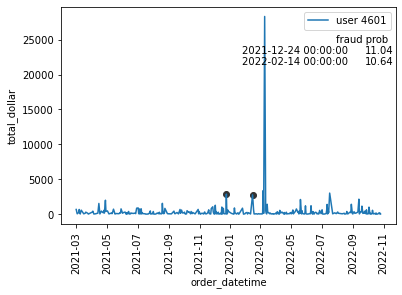

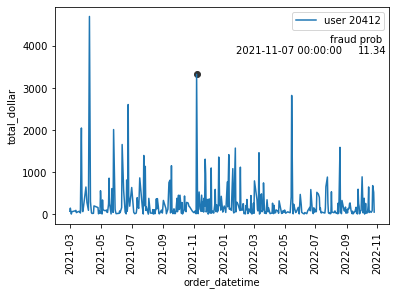

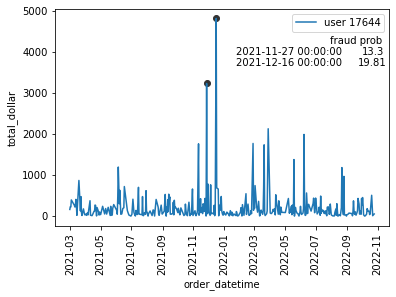

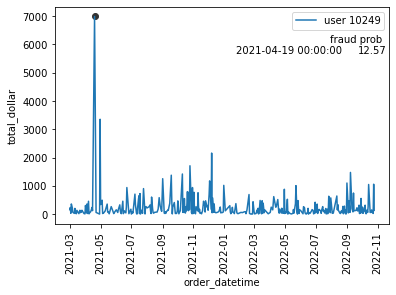

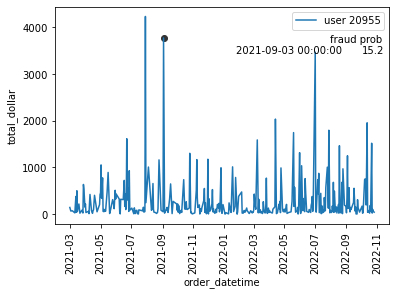

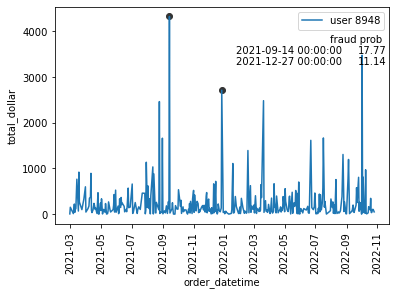

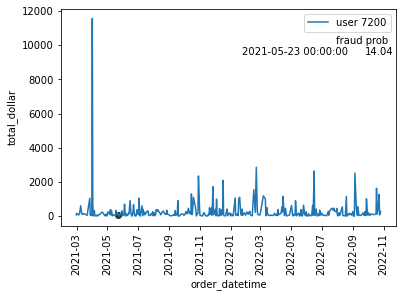

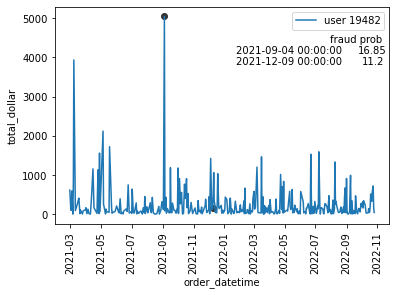

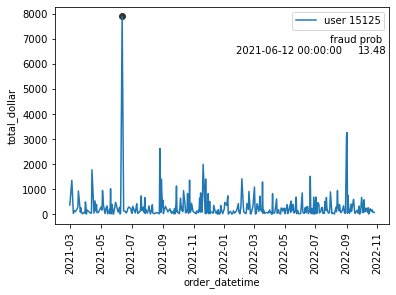

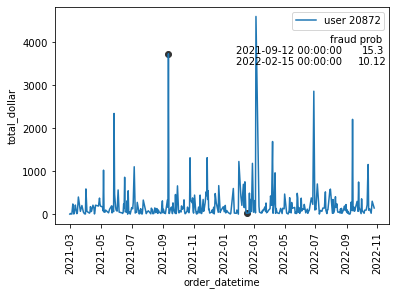

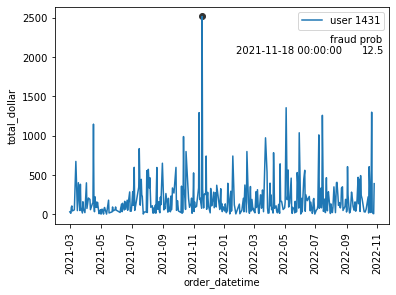

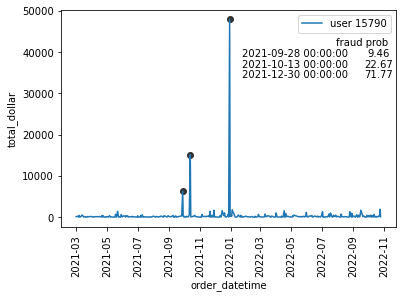

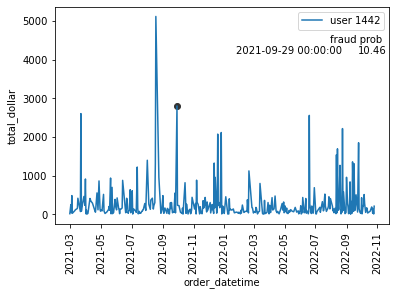

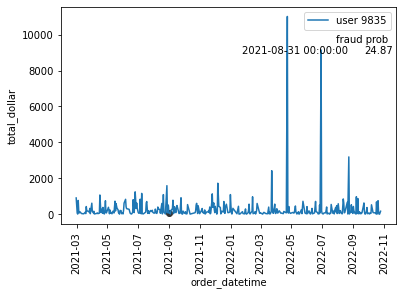

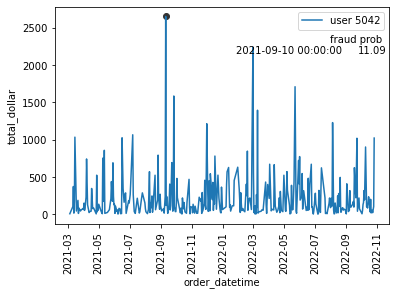

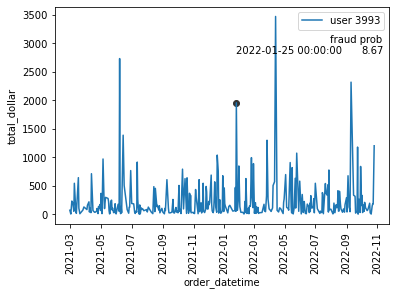

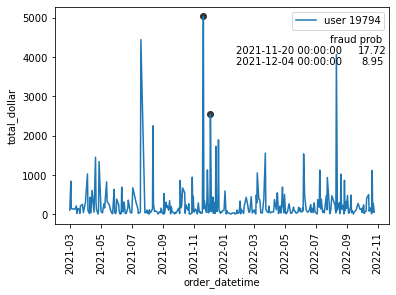

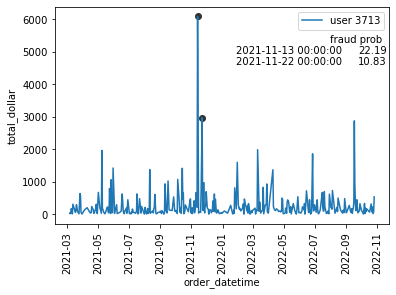

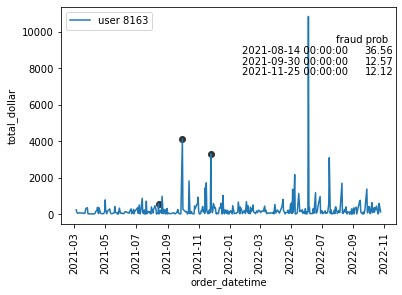

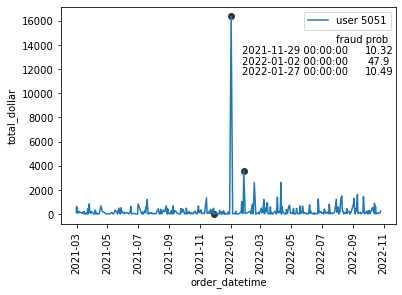

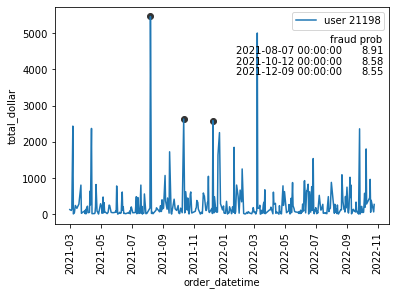

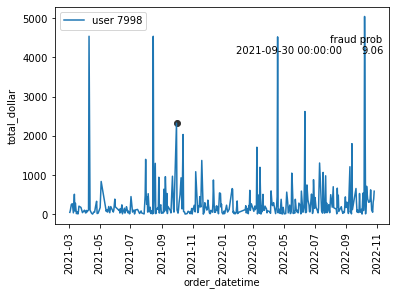

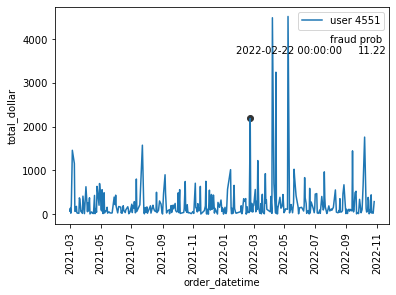

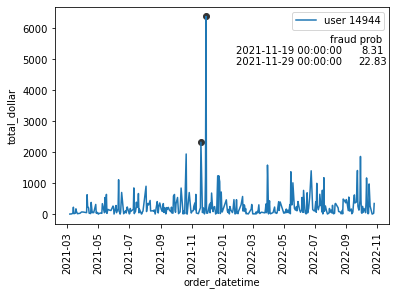

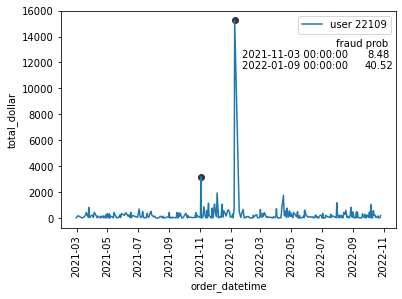

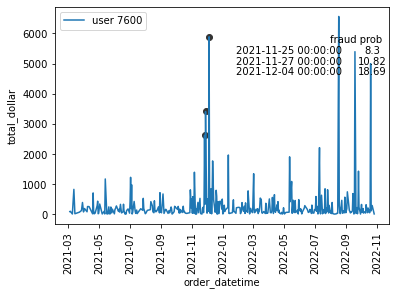

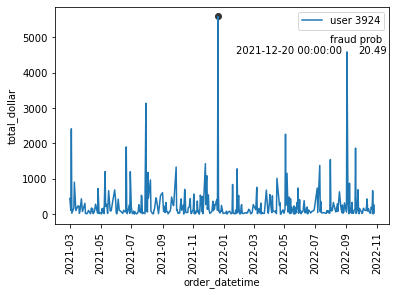

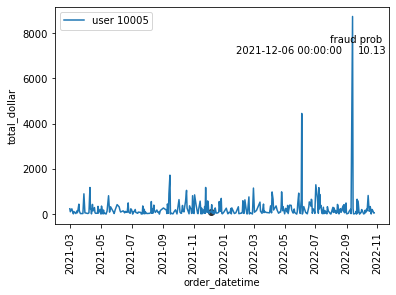

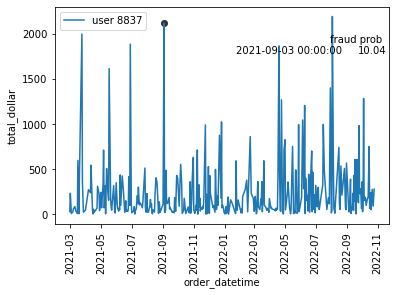

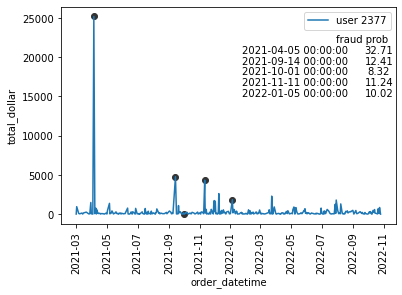

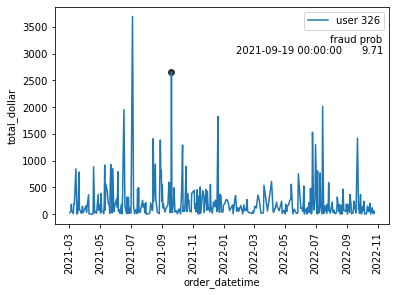

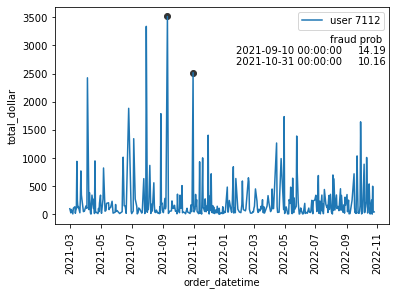

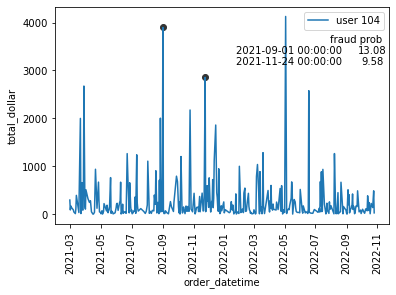

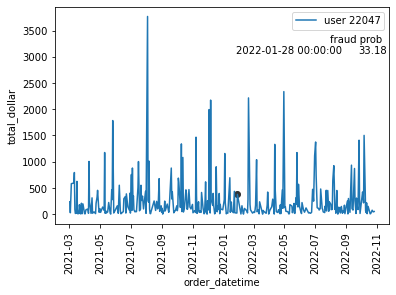

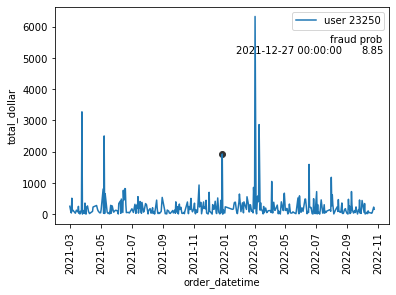

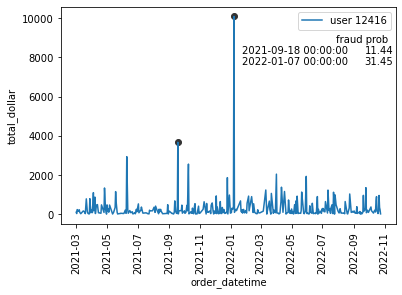

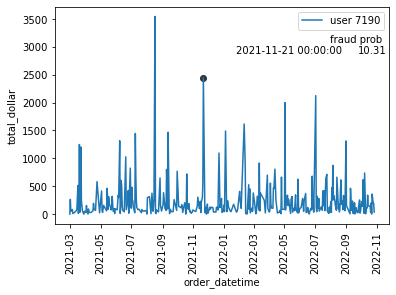

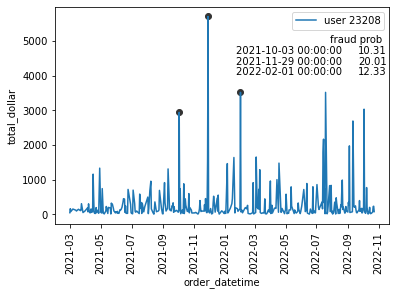

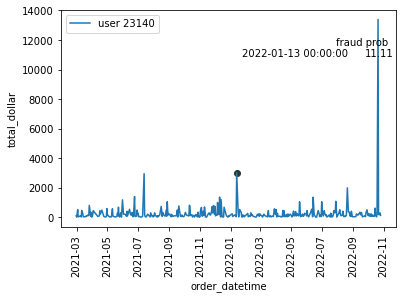

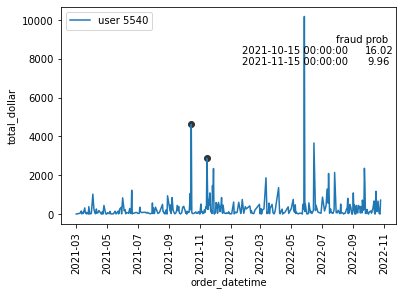

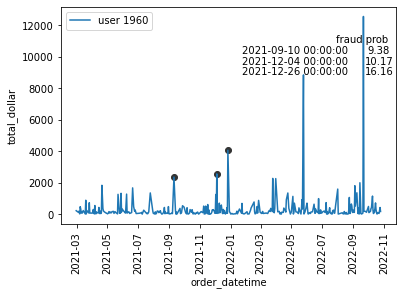

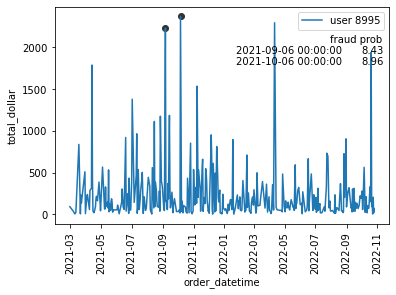

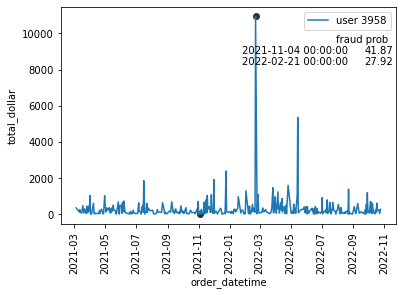

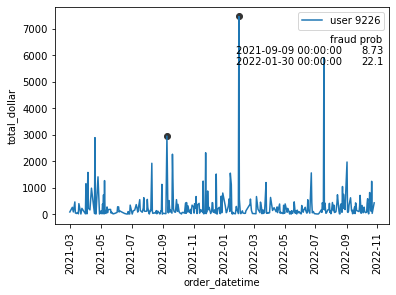

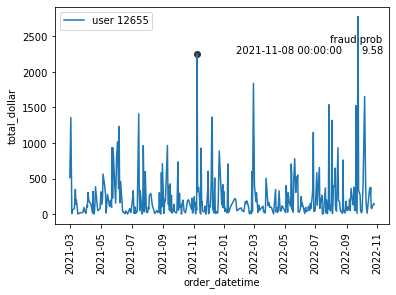

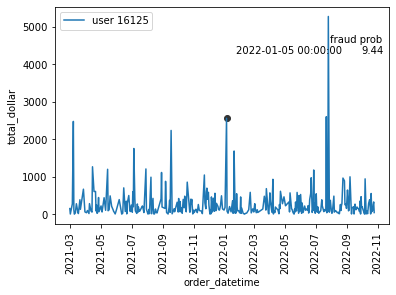

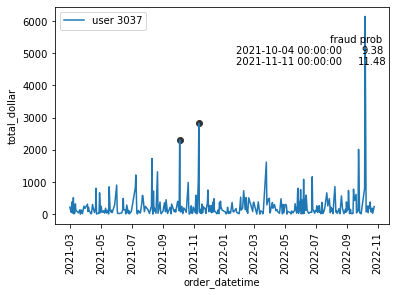

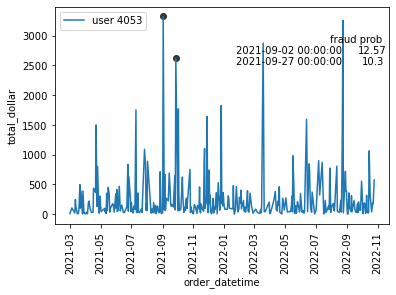

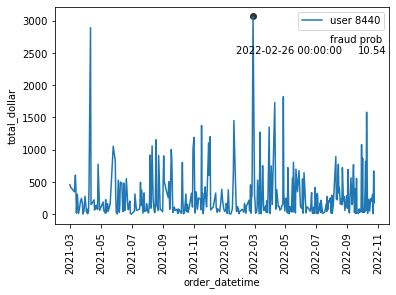

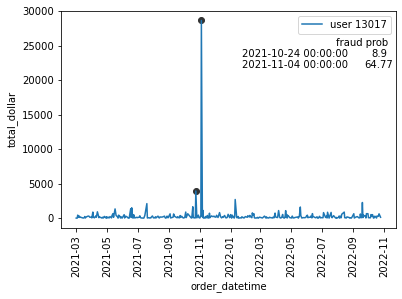

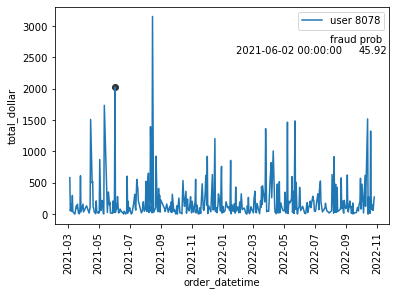

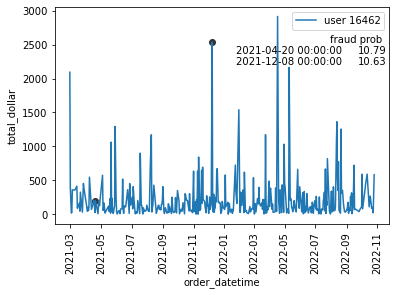

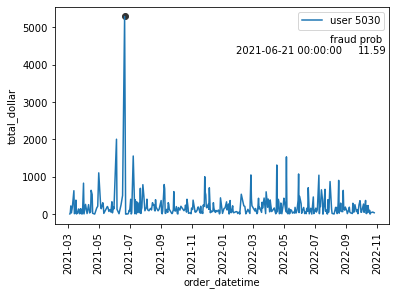

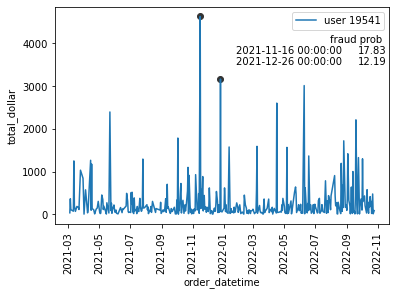

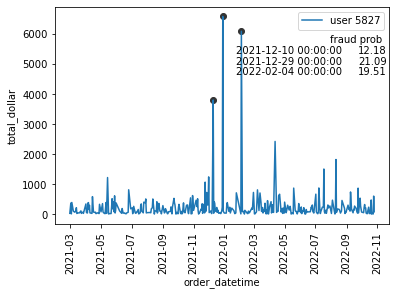

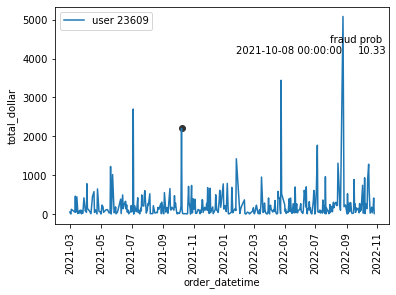

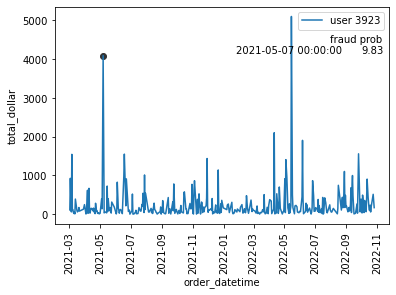

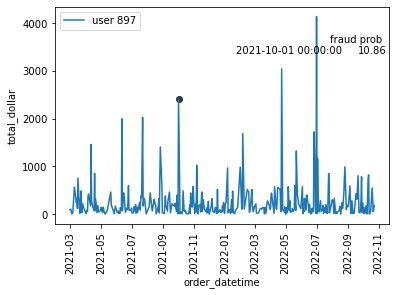

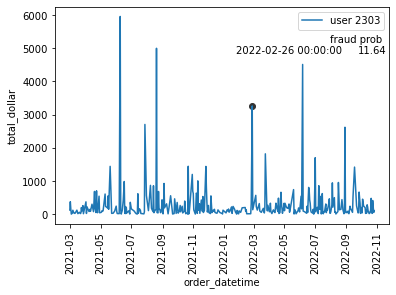

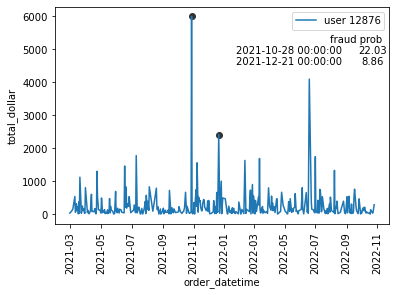

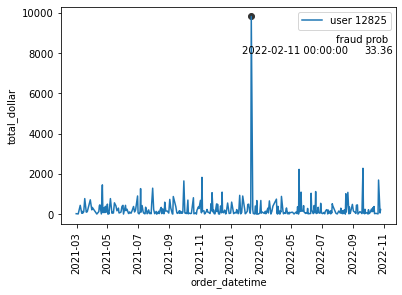

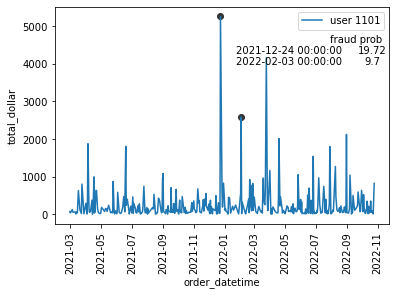

In [27]:
#### We will see 100 plots of each consumers and see if the transaction day and total amount spent that day relate
for user in fraud_consumers_sample:
    
    total_transactions = consumer_transactions_day[consumer_transactions_day['user_id']==user].sort_values(by=['order_datetime'])
    fraud = (consumer_fraud_total.loc[consumer_fraud_total['user_id']==user,['order_datetime','fraud_probability']]).drop_duplicates()
    fraud_dates = fraud['order_datetime'].values
    matched_dates = total_transactions[total_transactions['order_datetime'].isin(fraud_dates)]
    
    
    fig, ax = plt.subplots()
    ax = sns.lineplot(data = total_transactions, x='order_datetime', y='total_dollar')
    ax.scatter(matched_dates['order_datetime'], matched_dates['total_dollar'], marker='o',color=".2")
    ax.text(0.9, 0.85, 'fraud prob', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    i = 0.1
    for index, row in fraud.iterrows():
        ax.text(0.95, 0.9-i, round(row['fraud_probability'],2), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        ax.text(0.7, 0.9-i, row['order_datetime'], horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        i += 0.05
    ax.legend([f'user {user}'])
    plt.xticks(rotation=90)
    
    
    


From the graphs, we can see that most of the suspected fraudulants transactions are due to consumers making a big purchase on a single day compared to the rest of his/her spendings on other days. Although it is not every case, we do see lots of similarities where an unusually big spending on a single day was flagged and we should account for that fact that these are not all the fraud data available to us. It would be best to come up with a simple model to see surprising purchases from a consumer and removing that whole day's worth of transactions as it could be due to fraud. Some disadvantages of these would be we are disregarding the assumption that consumers may have a big purchase in a case where they got their first paycheck or its a special day like their birthday.We also see that the values for fraud probability increases if the deviatian is much more from norm. 

<AxesSubplot:xlabel='fraud_probability', ylabel='Count'>

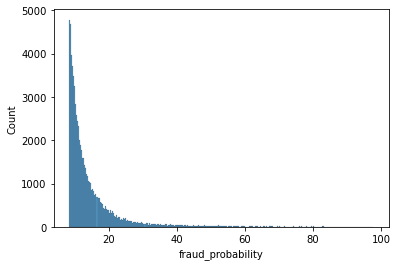

In [28]:
# We want to find distribution of the fraud rates in fraud data
sns.histplot(x=consumer_fraud_total['fraud_probability'])

Basically, we could do a outlier removal using quantiles 1 and 3 to get rid of those transactions so we reduce possible fraud transactions in the first place. But we will add probability, the further they are away, the more probability we remove them. Initial probability will be the median of 11% and to increase as it further deviates away from mean/median. 

In [29]:
consumer_fraud_prob.describe()

user_id  fraud_probability
count  34864.000000       34864.000000
mean   12057.003930          15.120091
std     6963.195641           9.946085
min        1.000000           8.287144
25%     6059.750000           9.634437
50%    12067.500000          11.735624
75%    18091.250000          16.216158
max    24081.000000          99.247380

# Merchant
Now we see for merchant data if it is the same case

In [30]:
merch_consumers= list(merchant_fraud_total['merchant_abn'].unique())
merch_consumers

[83199298021,
 91880575299,
 11149063370,
 15043504837,
 80089686333,
 90918180829,
 86889657711,
 14530561097,
 31334588839,
 18737319630,
 11470993597,
 19492220327,
 32258116290,
 97884414539,
 67264251405,
 93260930990,
 39649557865,
 50315283629,
 48534649627,
 96680767841,
 76767266140,
 21439773999,
 94493496784,
 93558142492,
 90568944804,
 18158387243,
 35909341340,
 27093785141,
 87084550311,
 82368304209,
 78080443264,
 79827781481,
 80518954462,
 22606727520,
 85482742429,
 93292821052,
 76968105359,
 72058040180,
 15157368385,
 43083074133,
 78187460332,
 11590404675,
 79100970961,
 97217894162,
 30275989942,
 23709946765,
 89109402284,
 35575706403]

In [31]:
merch_consumers_sample = random.choices(merch_consumers, k=100)

In [32]:
# Now we will collate all transactions relating to those merchants and group by day per merchant
merch_collated_transactions = transactions[transactions['merchant_abn'].isin(merch_consumers_sample)]
merch_transactions_day = merch_collated_transactions.groupby(['merchant_abn', 'order_datetime']).agg(total_dollar=pd.NamedAgg(column='dollar_value', aggfunc="sum")).reset_index()
merch_transactions_day

merchant_abn order_datetime  total_dollar
0       11149063370     2021-03-25  18256.649405
1       11149063370     2021-04-14  15909.174063
2       11149063370     2021-04-16   8896.344340
3       11149063370     2021-04-18  16106.237735
4       11149063370     2021-05-21  44013.844790
...             ...            ...           ...
15379   97884414539     2022-09-18  13387.476219
15380   97884414539     2022-10-05   3764.854143
15381   97884414539     2022-10-11  11397.634955
15382   97884414539     2022-10-15   9615.623757
15383   97884414539     2022-10-25   4849.990571

[15384 rows x 3 columns]

<ipython-input-33-93115fe073fc>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


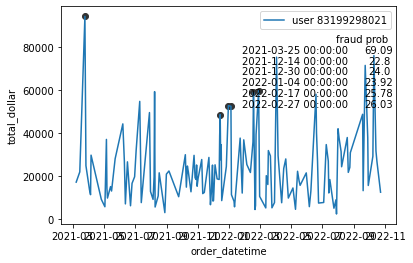

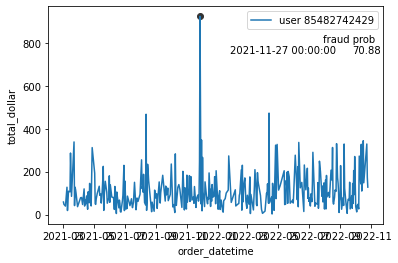

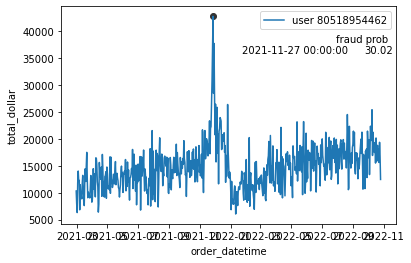

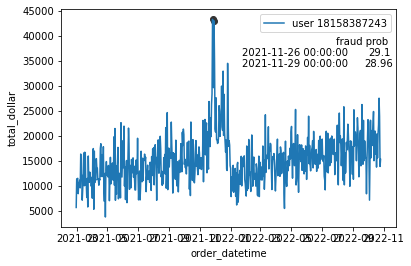

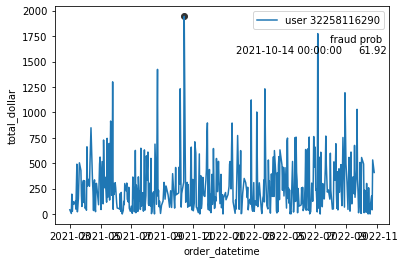

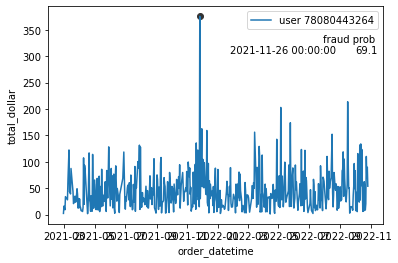

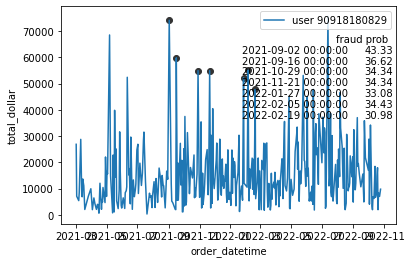

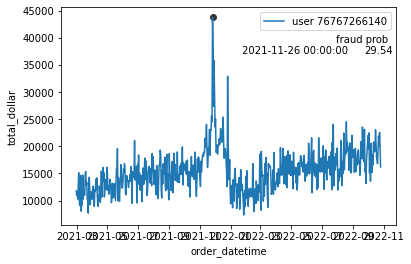

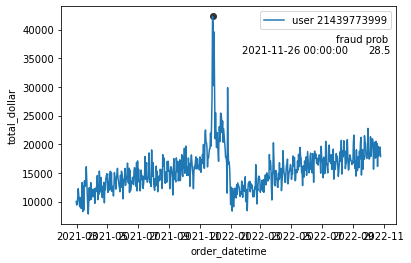

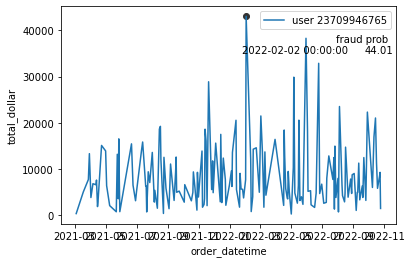

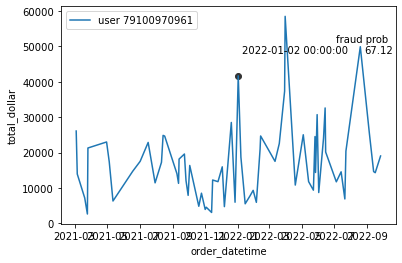

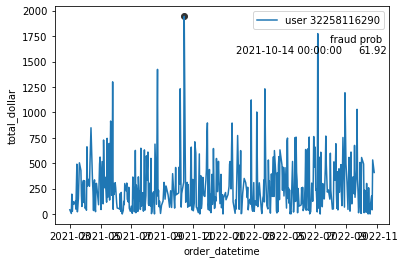

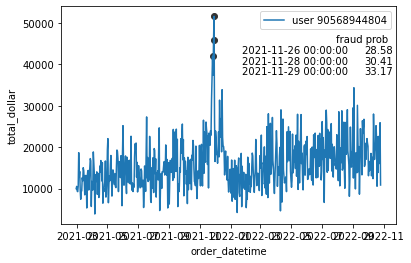

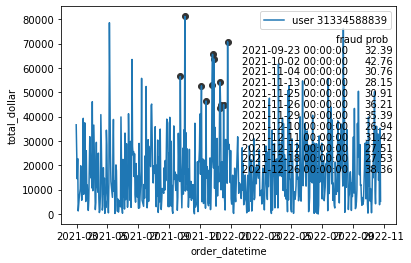

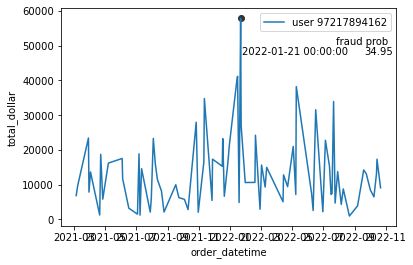

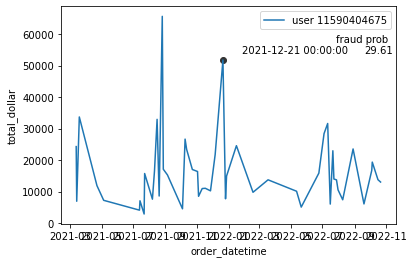

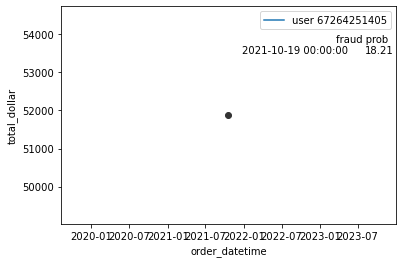

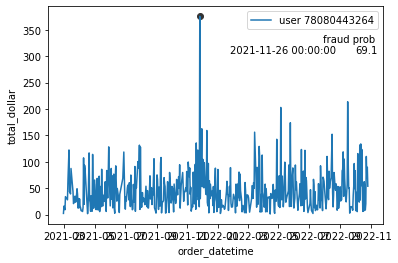

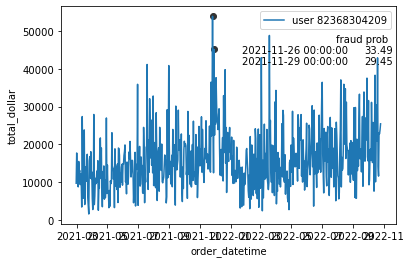

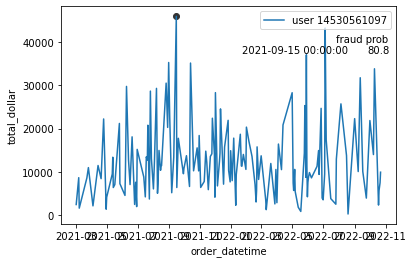

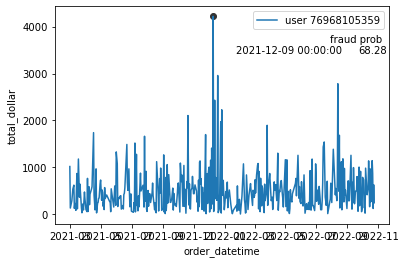

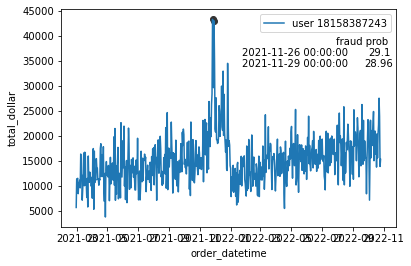

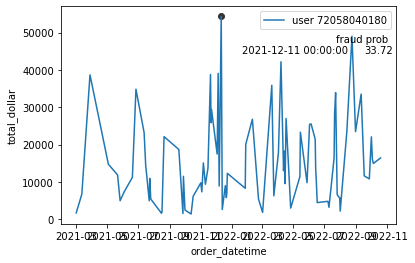

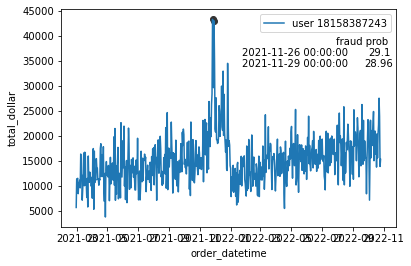

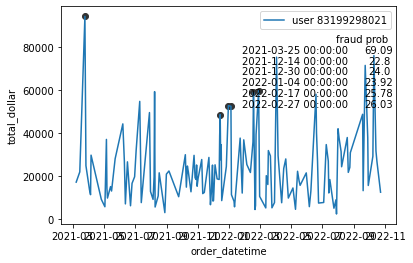

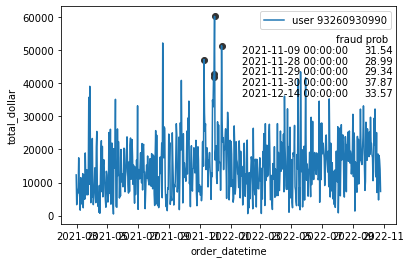

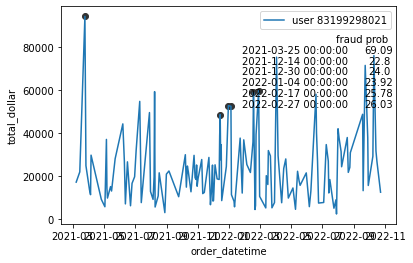

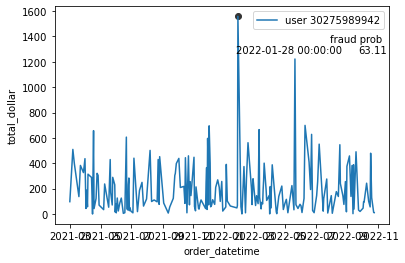

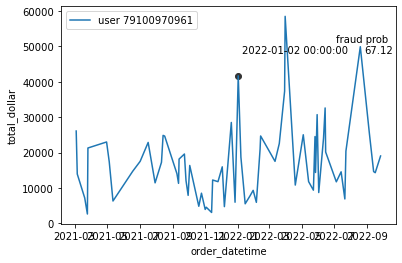

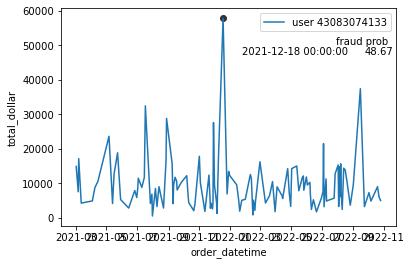

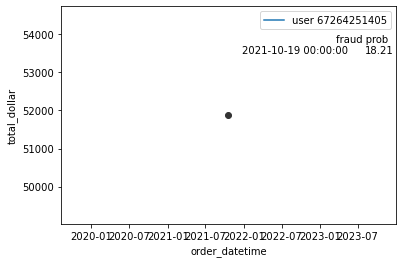

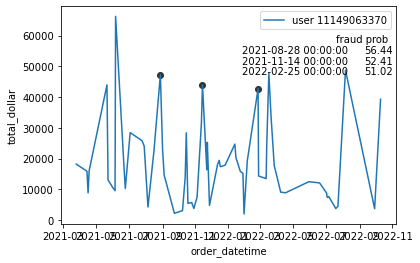

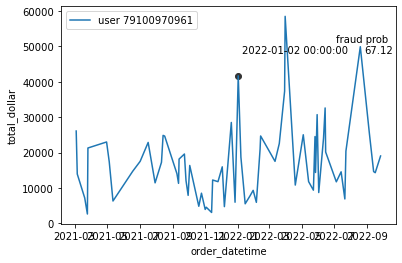

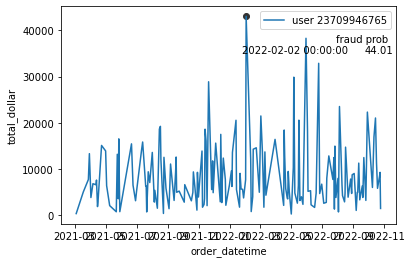

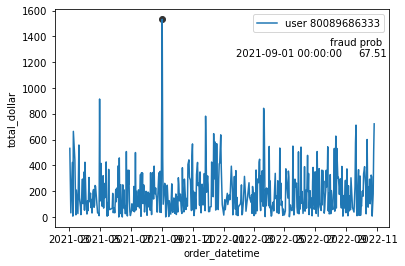

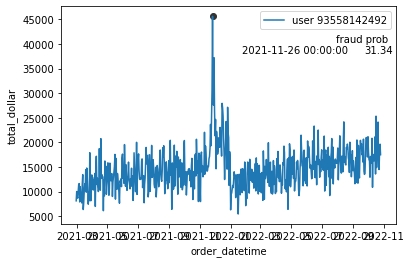

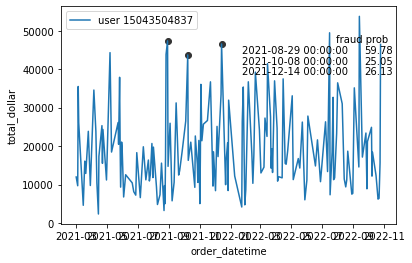

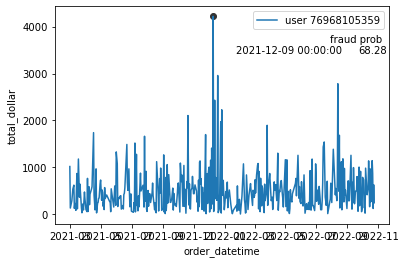

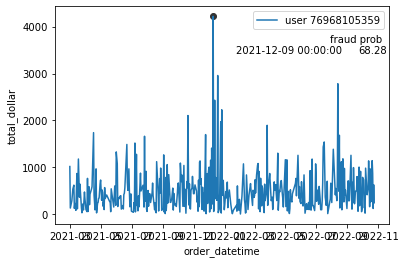

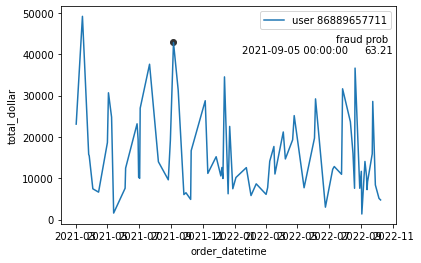

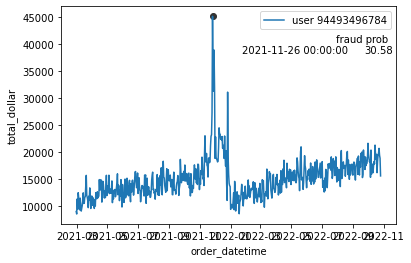

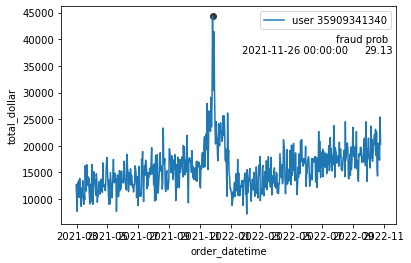

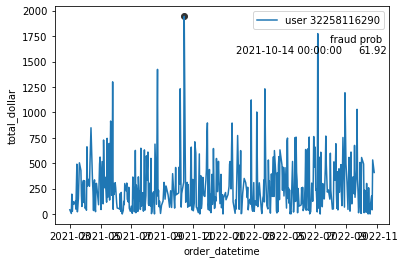

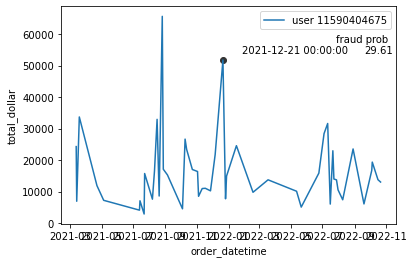

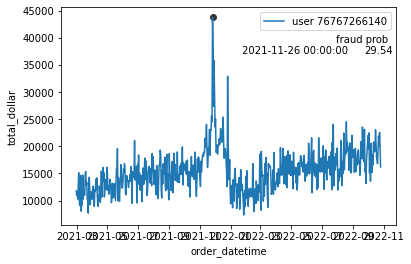

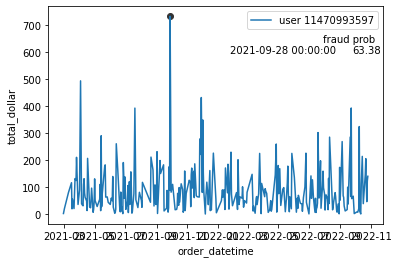

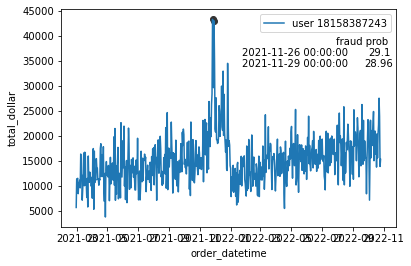

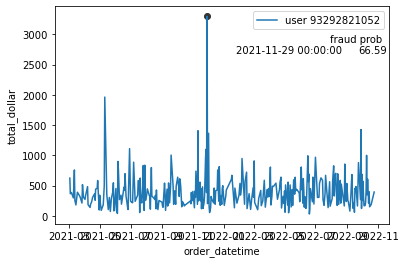

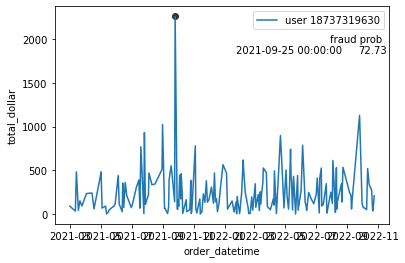

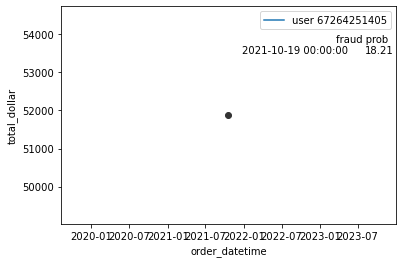

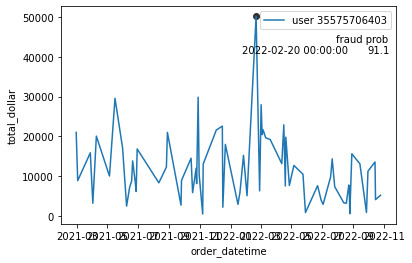

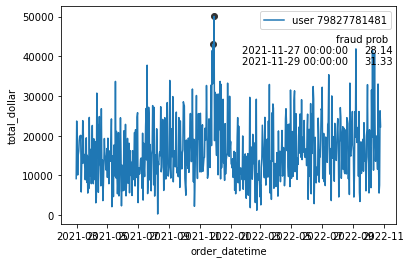

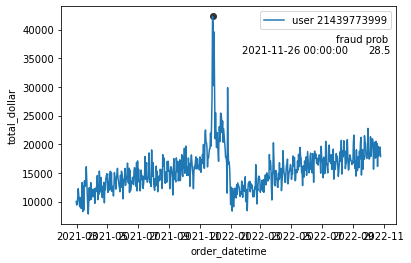

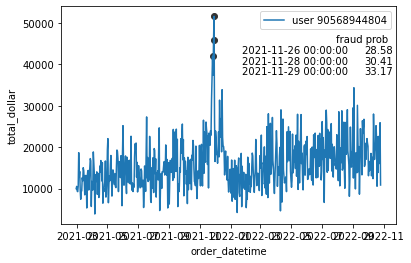

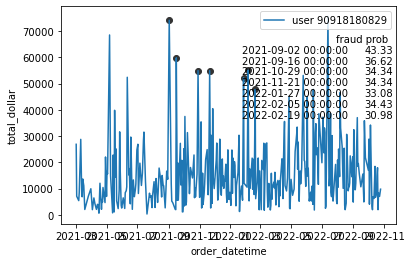

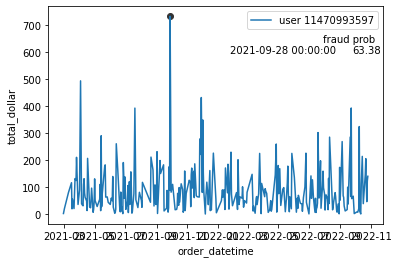

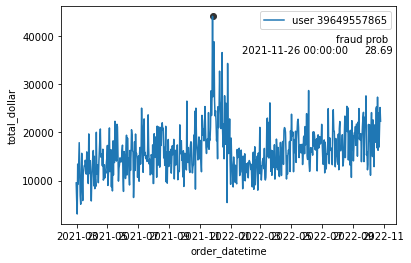

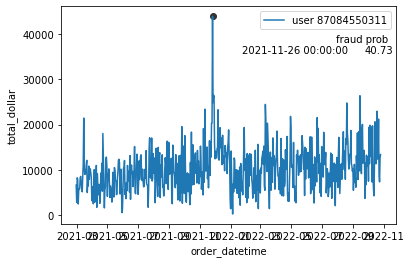

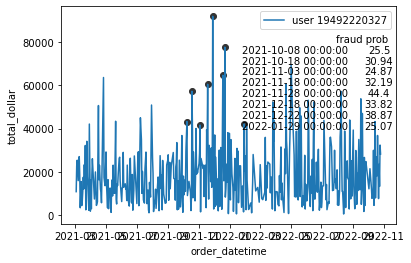

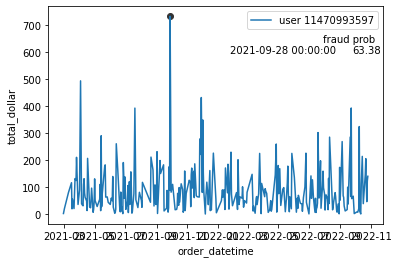

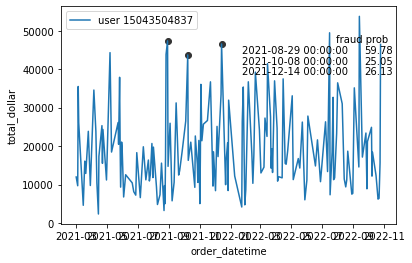

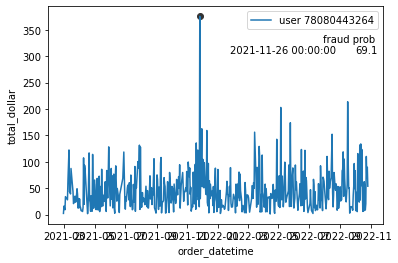

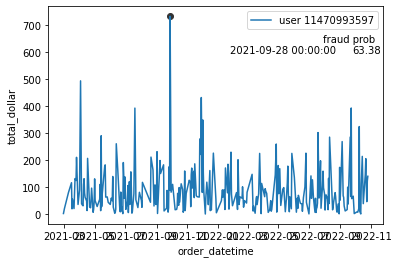

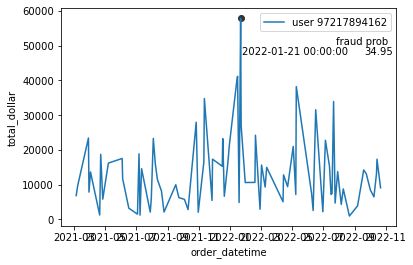

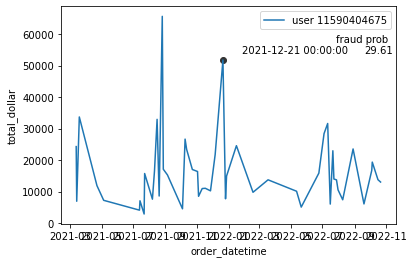

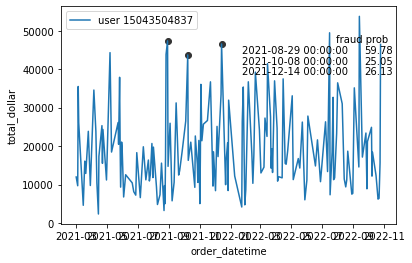

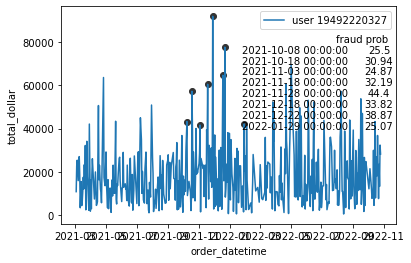

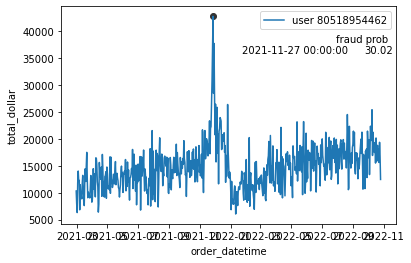

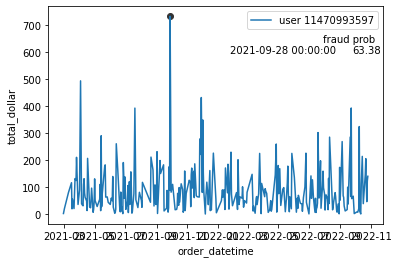

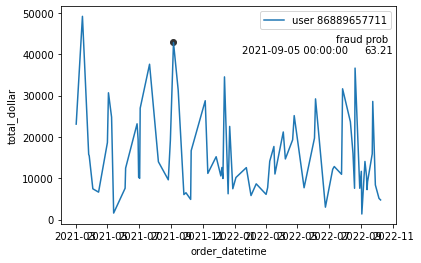

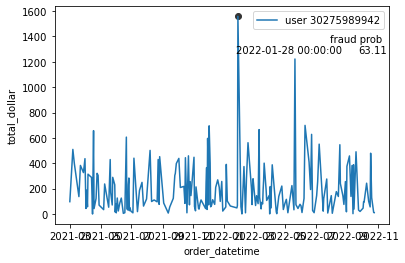

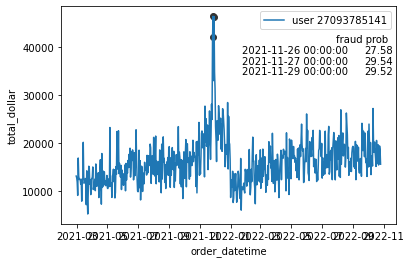

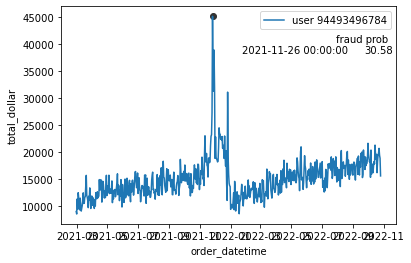

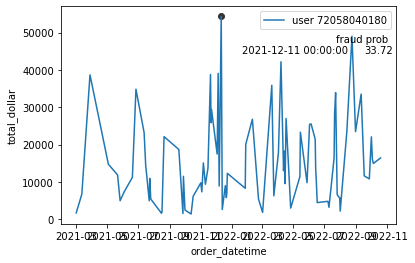

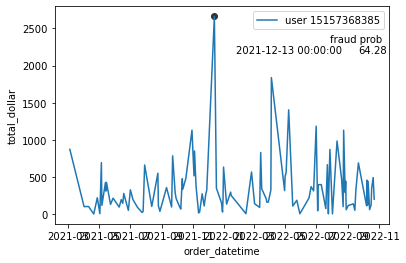

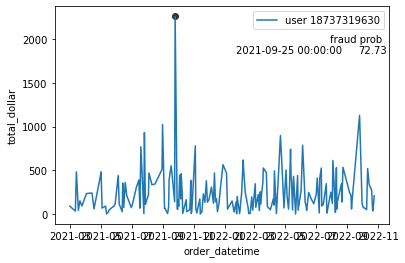

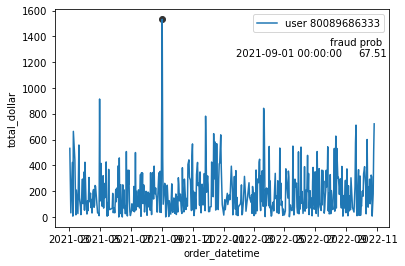

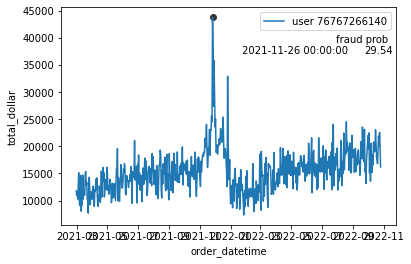

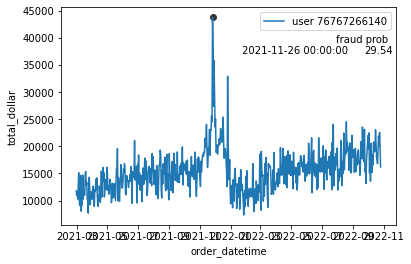

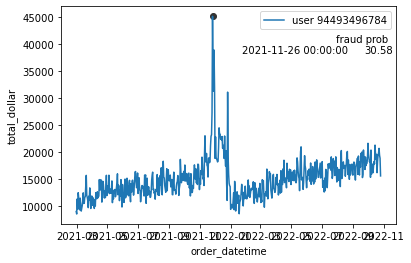

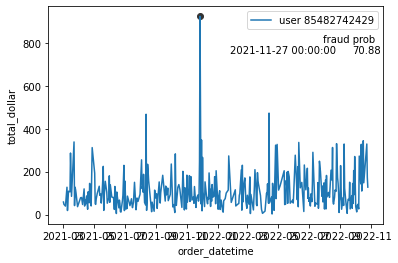

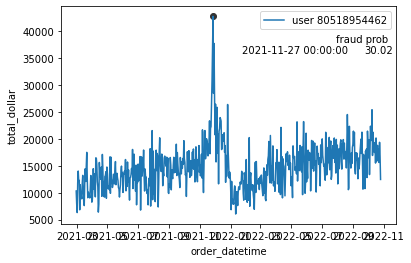

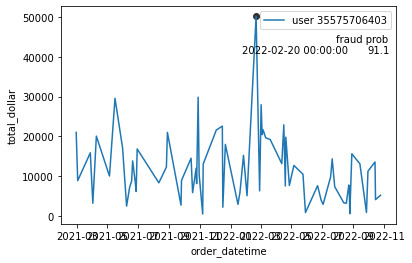

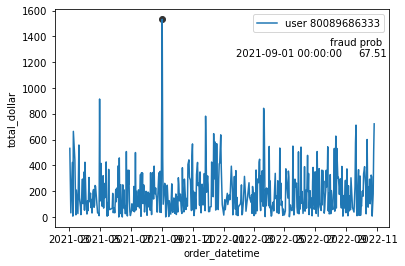

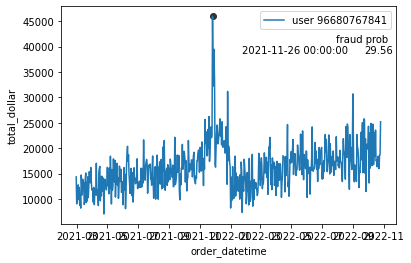

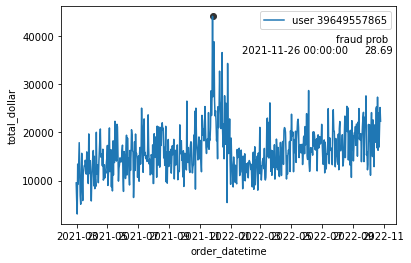

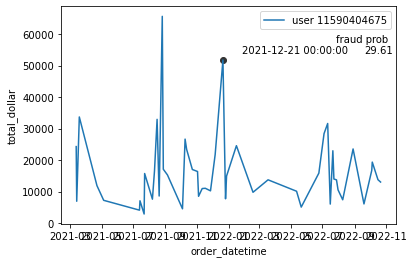

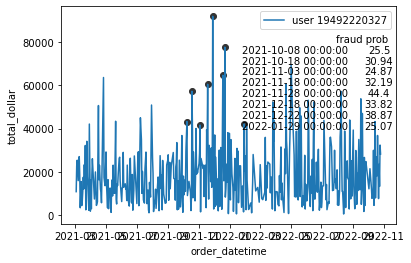

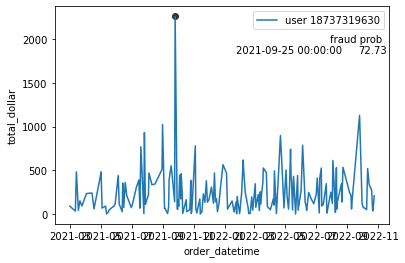

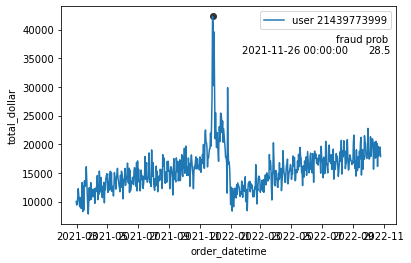

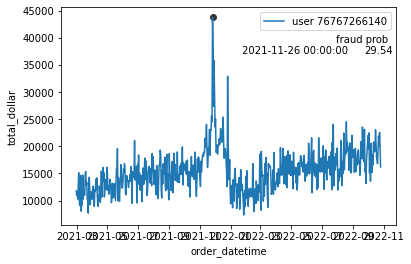

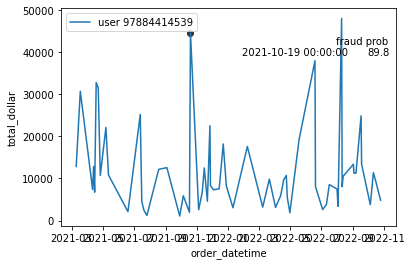

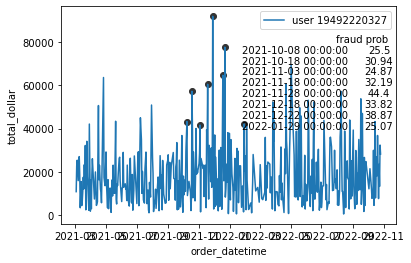

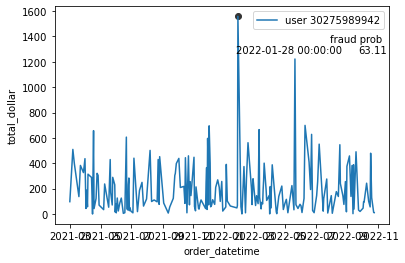

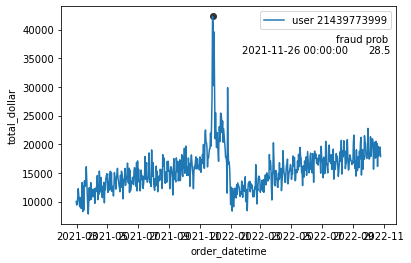

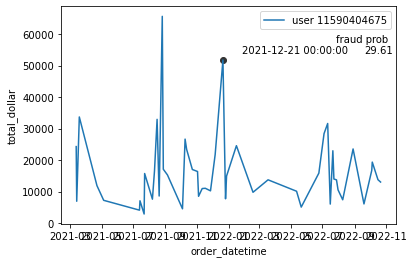

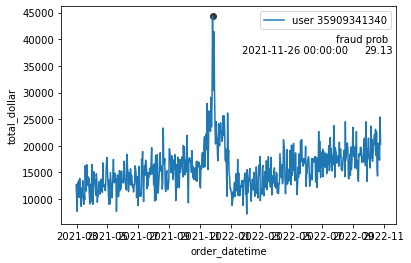

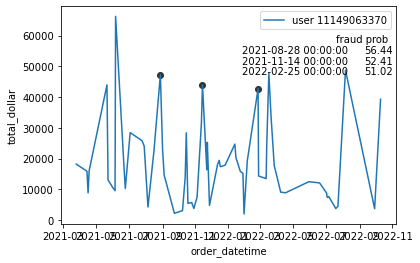

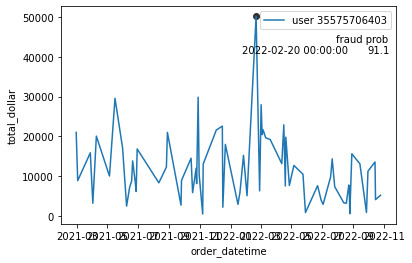

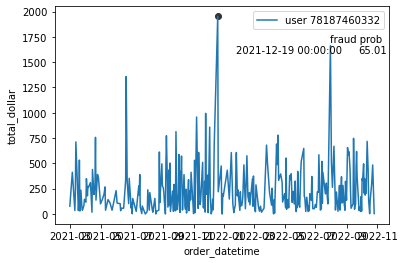

In [33]:
# We will see 100 plots of each merchants and see if the transaction day and total amount spent that day relate
for user in merch_consumers_sample:
    
    total_transactions = merch_transactions_day[merch_transactions_day['merchant_abn']==user].sort_values(by=['order_datetime'])
    fraud = (merchant_fraud_total.loc[merchant_fraud_total['merchant_abn']==user,['order_datetime','fraud_probability']]).drop_duplicates()
    fraud_dates = fraud['order_datetime'].values
    matched_dates = total_transactions[total_transactions['order_datetime'].isin(fraud_dates)]
    
    
    fig, ax = plt.subplots()
    ax = sns.lineplot(data = total_transactions, x='order_datetime', y='total_dollar')
    ax.scatter(matched_dates['order_datetime'], matched_dates['total_dollar'], marker='o',color=".2")
    ax.text(0.9, 0.85, 'fraud prob', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    i = 0.1
    for index, row in fraud.iterrows():
        ax.text(0.95, 0.9-i, round(row['fraud_probability'],2), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        ax.text(0.7, 0.9-i, row['order_datetime'], horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        i += 0.05
    ax.legend([f'user {user}'])
    
    

We see that it is the same case for merchants but if we do modelling for both, we will have clashes with the consumer fraud removals so we will only apply them to consumers.